In [47]:
from tensorflow.keras.models import load_model
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

loaded_model = load_model('../Learning_Code/saved_models/NVspin_GRU_model_Rho2RealNumber.h5')

2023-12-26 16:03:04.377645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-26 16:03:04.378992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-26 16:03:04.379926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [48]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_rho, x, y, z):
    
    new_x = np.array(x).reshape(-1, 1)
    new_y = np.array(y).reshape(-1, 1)
    new_z = np.array(z).reshape(-1, 1)
    
    predicted_sequence = loaded_model.predict([new_x, new_y, new_z])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)

    pulse_list = [U_0, U_1, U_2, U_3, U_4]

    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = state_fidelity(irho_final, target_rho)
    
    print(F)
    
    return F

In [49]:
def theta_x(theta, phi):
     return sin(theta)*cos(phi)

def theta_y(theta, phi):
     return sin(theta)*sin(phi)

def theta_z(theta):
     return cos(theta)

def making_rho(theta, phi):
     
     t_x = theta_x(theta, phi)
     t_y = theta_y(theta, phi)
     t_z = theta_z(theta)
     
     # Target state
     # Theta must move first and then phi move.
     target_U = Rz(target_phi) @ Rx(target_theta)
     irho_target = target_U @ irho_init @ target_U.conj().T
    
     return irho_target, t_x, t_y, t_z

In [50]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     
     target_theta = np.pi / 180 * random.uniform(0, 180)
     target_phi = np.pi / 180 * random.uniform(0, 360)
     
     target_rho, target_x, target_y, target_z = making_rho(target_theta, target_phi)
     
     temp = fidelity(target_rho, target_x, target_y, target_z)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp

print(sum/iter)

1/1 [==============================] - 0s 362ms/step


2023-12-26 16:03:04.863877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-26 16:03:04.865240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-26 16:03:04.866187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

0.9971711261537953
1/1 [==============================] - 0s 30ms/step
0.9938282927285389
1/1 [==============================] - 0s 15ms/step
0.9939229494952252
1/1 [==============================] - 0s 40ms/step
0.9981329817236968
1/1 [==============================] - 0s 20ms/step
0.9952837859580561
1/1 [==============================] - 0s 42ms/step
0.9962427928734617
1/1 [==============================] - 0s 30ms/step
0.9944543514255342
1/1 [==============================] - 0s 59ms/step
0.99586643835093
1/1 [==============================] - 0s 47ms/step
0.9972290731229013
1/1 [==============================] - 0s 78ms/step
0.9889026306006226
1/1 [==============================] - 0s 59ms/step
0.9967667844453278
1/1 [==============================] - 0s 60ms/step
0.9986586748842838
1/1 [==============================] - 0s 36ms/step
0.9996286796130351
1/1 [==============================] - 0s 62ms/step
0.9983177296457417
1/1 [==============================] - 0s 37ms/step
0.996830

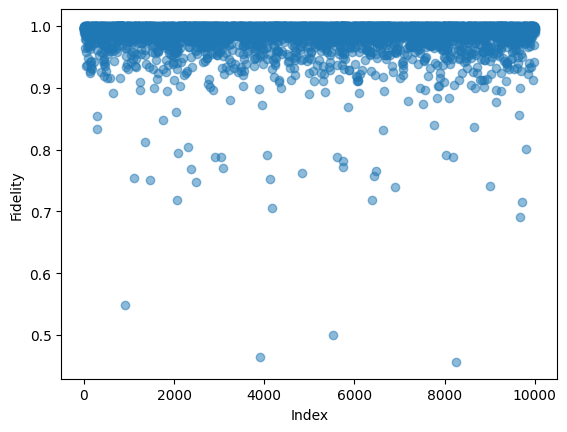

In [56]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Fidelity')
plt.show()

In [52]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

10 0.9889026306006226
20 0.9780870025771474
21 0.9855665383408825
24 0.9877518106664358
28 0.9898869841813605
31 0.9642033161011947
39 0.9847780807002092
40 0.9354160377139974
46 0.9831303930163002
51 0.9881802278328646
55 0.9770982380796847
59 0.9584034707255596
66 0.9361368782534787
68 0.9828357769313094
73 0.9862971701456833
74 0.9816432477378944
78 0.9651650479174231
79 0.9812862086918883
90 0.968512023589498
94 0.9858641348755778
95 0.9886285167150873
104 0.9480790300372127
110 0.9654971742823824
111 0.9899782031508136
112 0.9709860892263836
113 0.9865081284101305
126 0.9896435880876399
135 0.9263090355277501
141 0.9625467451657856
142 0.9230567405868011
145 0.9419647044710178
146 0.9817289848809051
148 0.9838817679411379
152 0.9438537262256954
160 0.9313221934187135
163 0.9896726226907006
165 0.9860940536905086
166 0.9372374863049249
170 0.9723559957742581
181 0.969775911387936
186 0.9899557427722285
187 0.9305085350962395
194 0.9880402963122129
203 0.9873634179865508
217 0.98921

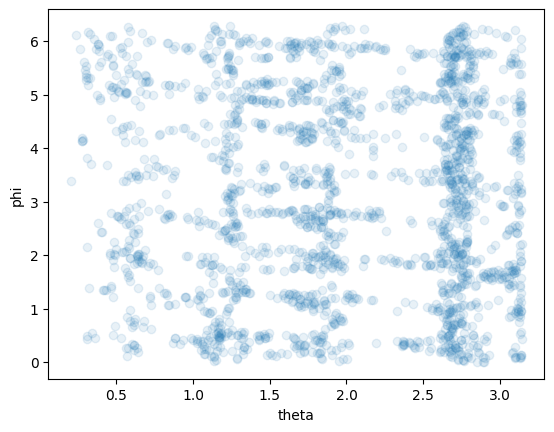

In [53]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.1)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

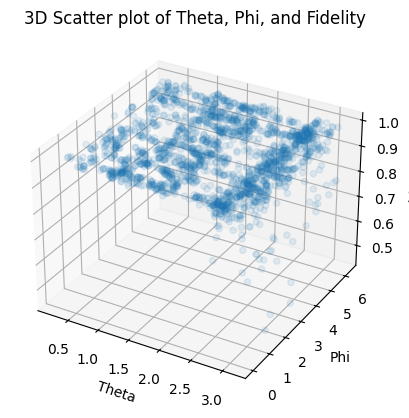

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.1)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()


In [55]:
# 피델리티 몇개 확인 99.99

optimal_fid = []

for i in fidelities:
     if i > 0.9999:
          optimal_fid.append(i)

# print(optimal_fid)
print(len(optimal_fid))
print(len(fidelities))
print(len(low_fidelities))

192
10000
3
